In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [23]:
gdf = pd.read_csv("teams.csv", index_col="team_name")

In [27]:
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.GeoSeries.from_wkt(gdf.arena_latlong), crs="EPSG:4326")

In [43]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

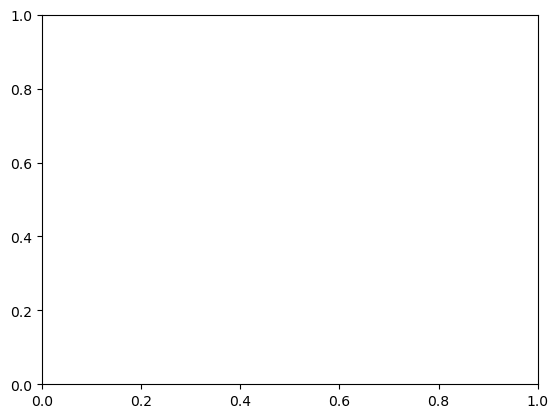

In [47]:
m = world[world.name == "United States of America"].explore()
gdf.explore(m=m, color="red")